## Clifford Fourier Transform for color images

This code corresponds the implementation described in:
"Color object recognition based on a clifford fourier transform". 
Jose Mennesson, Christophe Saint-Jean, and Laurent Mascarilla. 
In book "Guide to Geometric Algebra in Practice". Springer, 2011.

Python code here is an adaptation of Matlab code by the previous authors.

In [1]:
from sympy.galgebra import *


In [ ]:
def color_fourier_house(h, w, colors):
    def sin(theta, A, f, phi):
        h_, w_ = np.meshgrid(range(h),range(w))
        return A * np.sin(f * (h_ * np.cos(theta) + w_ * np.sin(theta)) + phi)
    def square
    

In [1]:
from scipy.misc import imread

## Get Image from file
def image_from_file(filename): 
    return imread(filename)
## Get Image for url
def image_from_url(url):
    from requests import get
    from StringIO import StringIO   
    return image_from_file(StringIO(get(url).content))

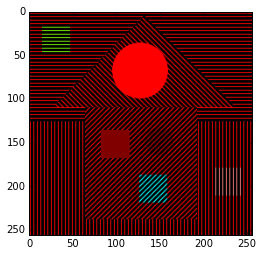

(256, 256, 3)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
urls =['https://hal.archives-ouvertes.fr/hal-00332912v2/file/Fhouse_color.png',
       'http://www.cs.cmu.edu/~chuck/lennapg/lena_std.tif']
# just to open image from url
image = image_from_url(urls[0])[:,:,0:3]/255.
plt.imshow(image)
plt.show()
print image.shape

In [4]:
import numpy as np

def get_basis(c1, c2 = None):
    c1 /= c1 np.linalg.norm(c1)
    if c2 is None:  
        mu = np.ones(3)/np.sqrt(3)
        if np.allclose(np.cross(c1, mu), np.zeros(3)):
            mu = np.array([1.,0,0])
        c3 = np.cross(c1,np.cross(mu,c1))
        c4 = np.cross(c3, c1)
        return np.append(c1,0), np.array([0,0,0,1.]), np.append(c3,0), np.append(c4,0)
    else:
        c2 /= np.linalg.norm(c2)
        c3 = np.cross(c1, c2)
        c2 = -np.cross(c1, c3)
        return np.append(c1,0), np.append(c2,0), np.append(c3,0), np.array([0,0,0,1.])
        
    
    
def cfft2(image, basis, reconstruction = False):
    h,l,_ = image.shape
    c, e4, v , w = basis
    image = np.dstack((image, np.zeros((h,l))))
    # Computation of two FFT2s on the two projected Image
    output = {}
    output['parallel'] = np.fft.fft2(np.dot(image, c) + 1j* np.dot(image, e4))
    output['orthogonal'] = np.fft.fft2(np.dot(image,v) + 1j *np.dot(image, w))
    if reconstruction is True:
        output['reconstruction'] = np.outer(output['parallel'].real,c)
        output['reconstruction'] += np.outer(output['parallel'].imag, e4)
        output['reconstruction'] += np.outer(output['orthogonal'].real, v)
        output['reconstruction'] += np.outer(output['orthogonal'].imag, w)
        output['reconstruction'] = np.reshape(output['reconstruction'],(h,l,4))
    return output

def icfft2(image, c, reconstruction = False):
    h,l,_ = image.shape
    image = np.dstack((image, np.zeros((h,l))))
    c = c/np.linalg.norm(c)
    mu = np.ones(3)/np.sqrt(3)
    if np.allclose(np.cross(c, mu), np.zeros(3)):
        mu = np.array([1.,0,0])
    v = np.cross(c,np.cross(mu,c))
    w = np.cross(v,c)
    c, e4, v , w = np.append(c,0), np.array([0,0,0,1.]), np.append(v,0), np.append(w,0)
    # Computation of two FFT2s on the two projected Image
    output = {}
    print c, e4, v , w
    output['parallel'] = np.fft.fft2(np.dot(image, c) + 1j* np.dot(image, e4))
    output['orthogonal'] = np.fft.fft2(np.dot(image,v) + 1j *np.dot(image, w))
    if reconstruction is True:
        output['reconstruction'] = np.outer(output['parallel'].real,c)
        output['reconstruction'] += np.outer(output['parallel'].imag, e4)
        output['reconstruction'] += np.outer(output['orthogonal'].real, v)
        output['reconstruction'] += np.outer(output['orthogonal'].imag, w)
        output['reconstruction'] = np.reshape(output['reconstruction'],(h,l,4))
    return output

[ 1.  0.  0.  0.] [ 0.  0.  0.  1.] [-0.          0.57735027  0.57735027  0.        ] [ 0.          0.57735027 -0.57735027  0.        ]


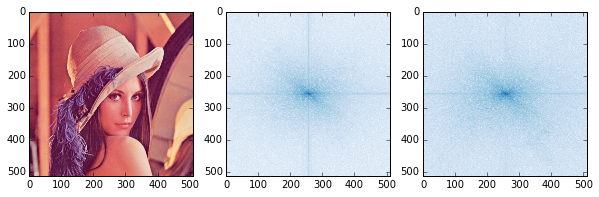

In [5]:
from IPython.html.widgets import interact
from IPython.html import widgets
r_slider = widgets.IntSliderWidget(min=0, max=255, step=1, value=255)
g_slider = widgets.IntSliderWidget(min=0, max=255, step=1, value=0)
b_slider = widgets.IntSliderWidget(min=0, max=255, step=1, value=0)
    
def f(r,g,b):
    R = cfft2(image,np.array([r,g,b]))
    fig, ax = plt.subplots(1, 3, figsize=(10,5)) 
    ax[0].imshow(image)           
    ax[1].imshow(np.log(1+np.abs(np.fft.fftshift(R['parallel']))), plt.cm.Blues)
    ax[2].imshow(np.log(1+np.abs(np.fft.fftshift(R['orthogonal']))), plt.cm.Blues)
              
interact(f, r=r_slider, g=g_slider, b=b_slider)

In [5]:
radius_slider = widgets.IntSliderWidget(min=0, max=255, step=1, value=11)
R = cfft2(image,np.array([r,g,b]))
def low_pass_filter(r):
    
    

IndentationError: expected an indented block (<ipython-input-5-bc38cda7a96b>, line 5)